# Import packages

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
from importlib import reload
import json
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import patch_seq_spl.helper_functions as src
from utility.ryp import r, to_r

Loading required package: svglite


In [18]:
r(
"""
library(readr)
library(ggplot2)
library(magrittr)
library(dplyr)
library(tidyr)
library(ggvenn)
"""
)


Attaching package: ‘magrittr’

The following object is masked from ‘package:arrow’:

    is_in


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract

Loading required package: grid


# Plotting

## Proportions of sig genes that are ion channels

In [3]:
glm_results = src.get_glm_results("proc/scquint/three/simple")

In [12]:
glm_results.glm.rank_introns_by_n_sig_corr("all", True, True).to_csv("sig_VGIC_SJ.csv")

In [ ]:
ephys_props = pd.read_csv("data/ephys_data_sc.csv", index_col = 0)
VGIC_prop = []
VGIC_count = []
for predictor in glm_results.columns:
    n_sig_gene_in_VGIC = len(glm_results.glm.get_sig_gene_list(predictor, VGIC_only=True))
    n_sig_gene = len(glm_results.glm.get_sig_gene_list(predictor, VGIC_only=False))
    ratio = n_sig_gene_in_VGIC / n_sig_gene
    VGIC_prop.append(ratio)
    VGIC_count.append(n_sig_gene_in_VGIC)

VGIC_prop = pd.Series(VGIC_prop, index = glm_results.columns, name = "proportion")\
    .to_frame()\
    .assign(type = lambda x: np.where(x.index.isin(ephys_props), "ephys", "categorical"))
VGIC_prop['type'] = VGIC_prop['type'].astype('category')

VGIC_count = pd.Series(VGIC_count, index = glm_results.columns, name = "count")\
    .to_frame()\
    .assign(type = lambda x: np.where(x.index.isin(ephys_props), "ephys", "categorical"))
VGIC_count['type'] = VGIC_count['type'].astype('category')

null device 
          1 


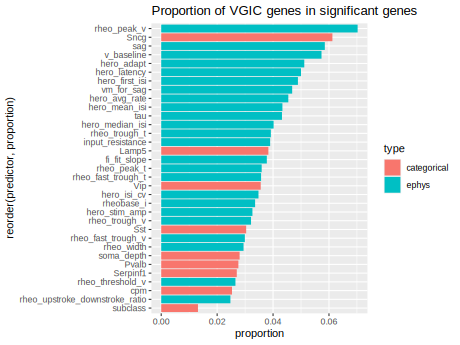

In [22]:
to_r(VGIC_prop, "VGIC_prop")
r(
"""
VGIC_prop %>% 
  as_tibble(rownames = "predictor") %>% 
  mutate(type = as.factor(type)) %>% 
  ggplot(aes(x = proportion, y = reorder(predictor, proportion), fill = type)) +
    geom_bar(stat = "identity") +
    ggtitle("Proportion of VGIC genes in significant genes")
"""
  )

null device 
          1 


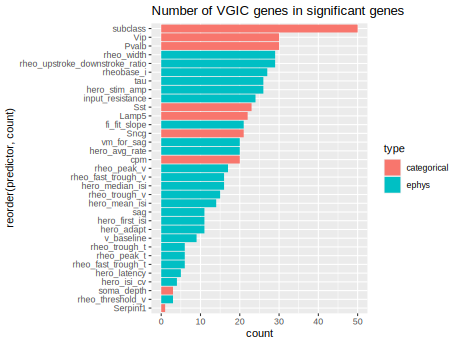

In [8]:
to_r(VGIC_count, "VGIC_count")
r(
"""
VGIC_count %>% 
  as_tibble(rownames = "predictor") %>% 
  mutate(type = as.factor(type)) %>% 
  ggplot(aes(x = count, y = reorder(predictor, count), fill = type)) +
    geom_bar(stat = "identity") +
    ggtitle("Number of VGIC genes in significant genes")
"""
  )

In [9]:
subclass_individually = set(src.get_sig_gene_list(glm_results, "Vip"))\
    .union(*[set(src.get_sig_gene_list(glm_results, subclass_name)) for subclass_name in ["Sst", "Pvalb", "Sncg", "Serpinf1"]])
subclass_individually = list(subclass_individually)
to_r(subclass_individually, "subclass_individually")
to_r(src.get_sig_gene_list(glm_results, "subclass"), "subclass")

null device 
          1 


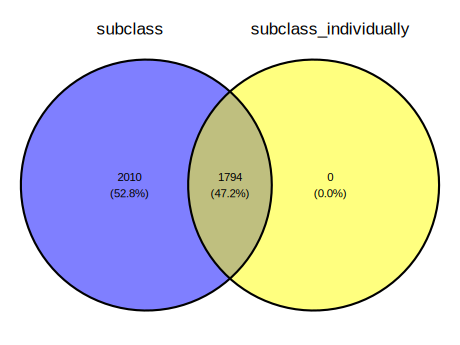

In [10]:
r(
"""
a <- list(
    subclass = subclass %>% unlist(),
    subclass_individually = subclass_individually %>% unlist())
ggvenn(a)
"""
)

## Number sig clusters that include at least one novel splice site

In [24]:
adata = anndata.read_h5ad("proc/scquint/preprocessed_adata_three.h5ad")
novel_dict = adata.var\
    .assign(annotation = lambda x: x.annotation.apply({0 : True, 1 : False}.get))\
    .groupby("intron_group")["annotation"].any().to_dict()
temp = glm_results\
    .applymap(lambda x: x < 0.05)\
    .assign(annotation = lambda x: x.index.map(novel_dict))\
    .groupby("annotation")\
    .sum().T\
    .rename(columns = {True : "novel", False : "known"})
to_r(temp, "temp")

null device 
          1 


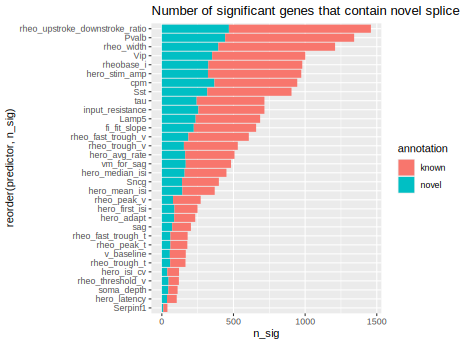

In [27]:
r(
"""
temp <- temp[-which(rownames(temp) == "subclass"), ]
temp %>%
    as_tibble(rownames = "predictor") %>%
    pivot_longer(cols = c("novel", "known"), names_to = "annotation", values_to = "n_sig") %>%
    ggplot(aes(x = n_sig, y = reorder(predictor, n_sig), fill = annotation)) +
        geom_bar(stat = "identity") +
        ggtitle("Number of significant genes that contain novel splice sites")
"""
)

In [132]:
reload(src)

<module 'patch_seq_spl.helper_functions' from '/Users/xunuo/projects/patch_seq_spl/patch_seq_spl/helper_functions.py'>

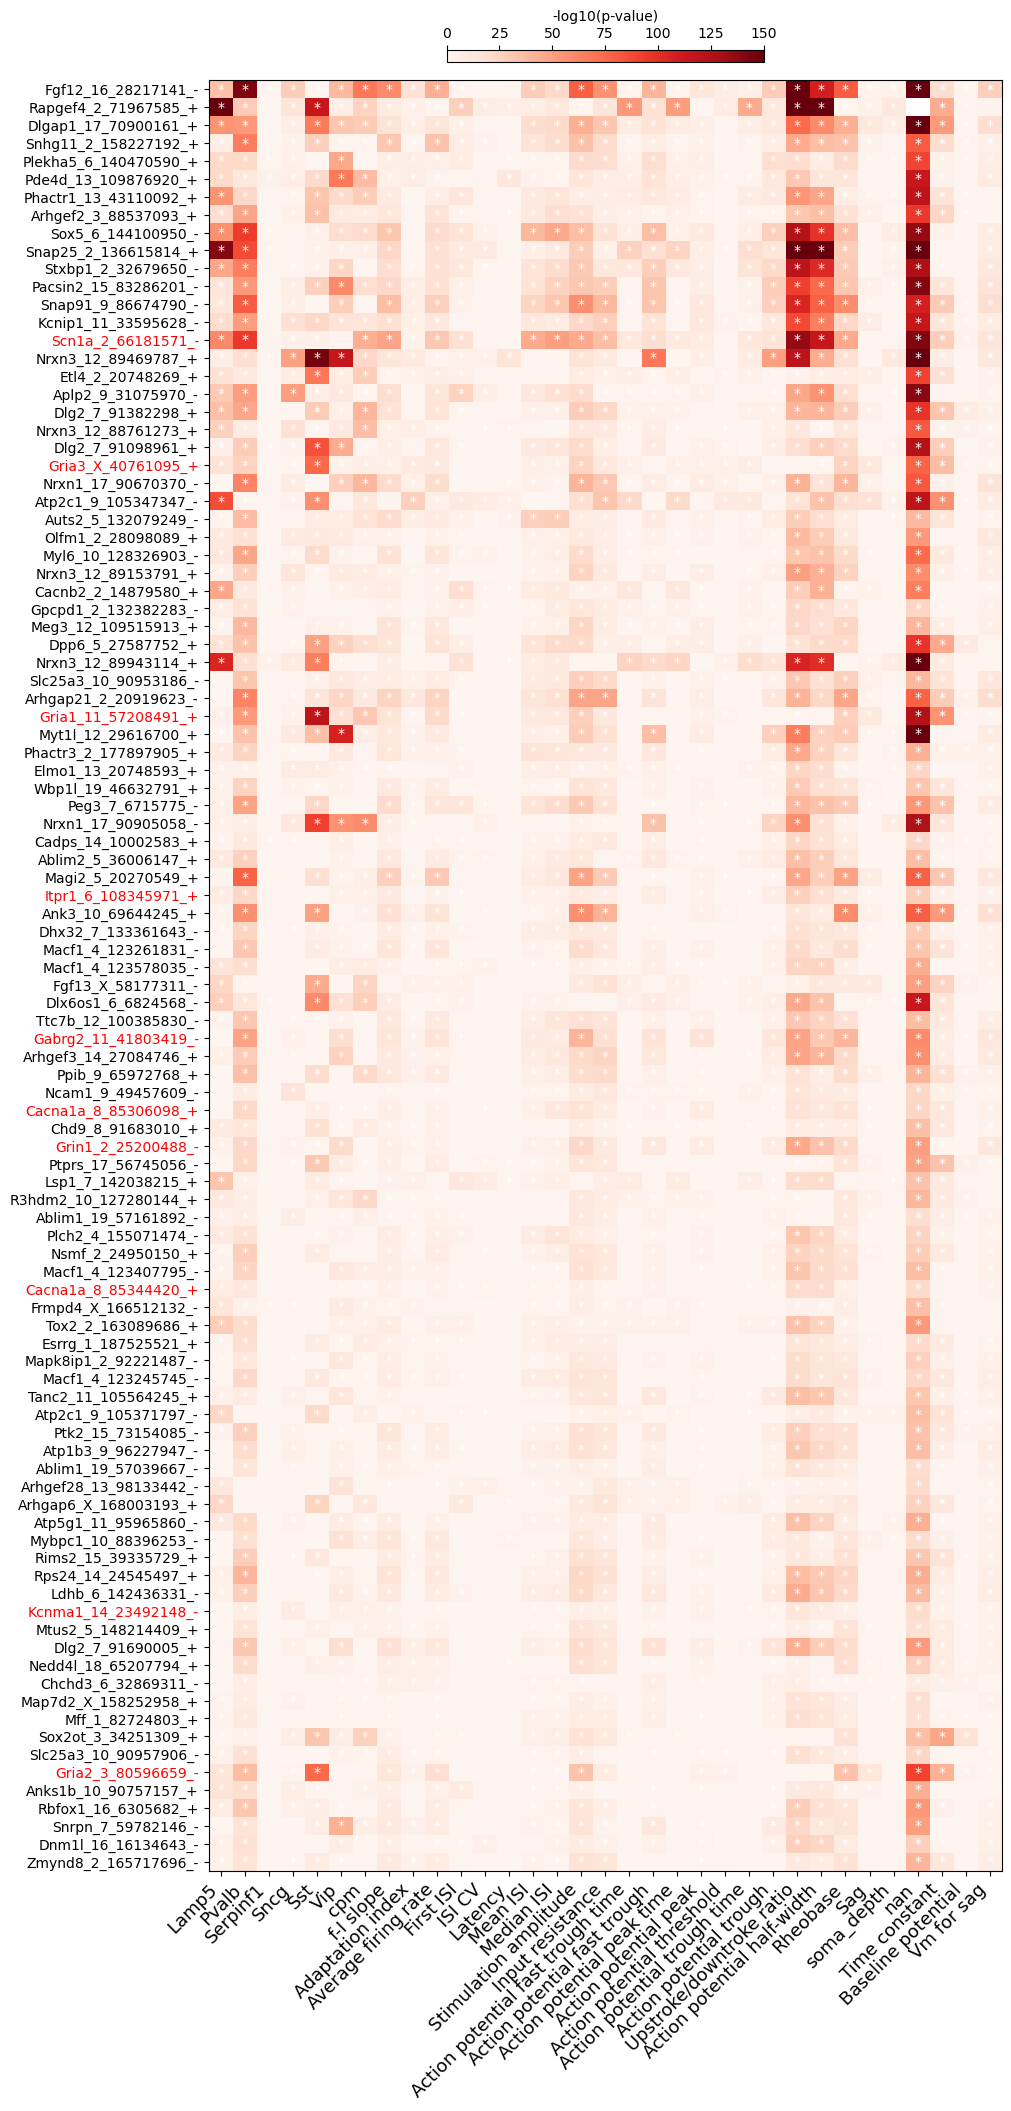

In [133]:
src.plot_glm_results("proc/scquint/three/simple")

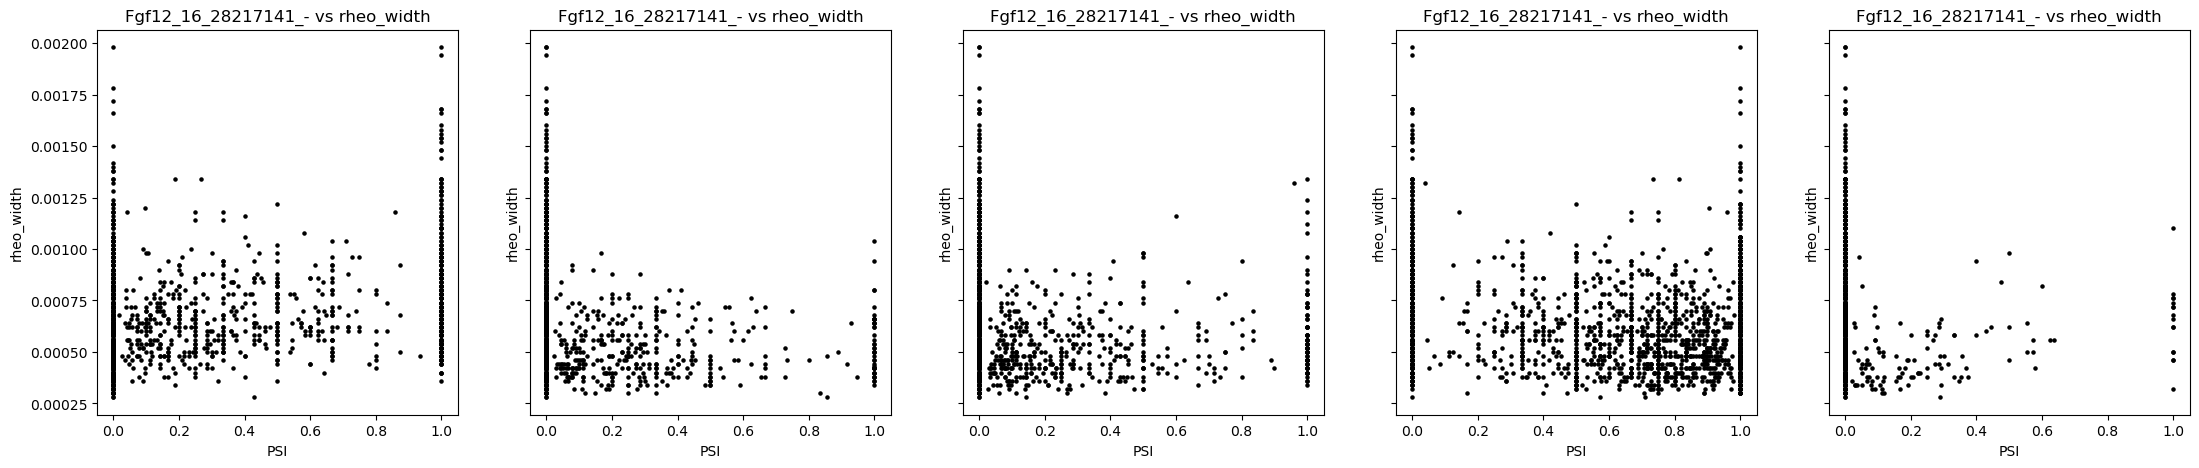

In [98]:
src.plot_intron_group_vs_ephys_prop(adata, "Fgf12_16_28217141_-", "rheo_width")

In [ ]:
transcriptomics_sample_id_file_name = json.load(open("data/mappings/transcriptomics_sample_id_file_name.json"))
cpm = pd.read_csv("data/20200513_Mouse_PatchSeq_Release_cpm.v2.csv", index_col = 0)
cpm = cpm.T
cpm.index = cpm.index.map(transcriptomics_sample_id_file_name)
cpm = cpm.reset_index().dropna(subset=["index"]).set_index("index") # drop NaN indices
ephys_data_sc = pd.read_csv("data/ephys_data_sc.csv", index_col = 0)
ephys_data_sc = ephys_data_sc.loc[(np.isnan(ephys_data_sc)).sum(axis = 1) < 6, :]
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
ephys_data_sc = pd.DataFrame(imp.fit_transform(ephys_data_sc), index=ephys_data_sc.index, columns=ephys_data_sc.columns)
commin_ids = np.intersect1d(ephys_data_sc.index, cpm.index)
ephys_data_sc = ephys_data_sc.loc[commin_ids]
cpm = cpm.loc[commin_ids]
cpm = cpm.loc[:, cpm.sum(axis = 0) > 20]
gene_ephys_rank_p = correlate(cpm.values, ephys_data_sc.values, rank = True).p
gene_ephys_rank_p = correlate(cpm.values, ephys_data_sc.values, rank = True).p
gene_ephys_rank_p = pd.DataFrame(
    fdrcorrection(gene_ephys_rank_p.flatten())[1].reshape(gene_ephys_rank_p.shape), 
    index = cpm.columns, 
    columns = ephys_data_sc.columns)
top_100 = gene_ephys_rank_p.loc[gene_ephys_rank_p.apply(lambda x: (x < 0.05)).sum(axis = 1).sort_values(ascending = False)[:100].index]

: 

/scratch/s/shreejoy/nxu/patch_seq_spl/env/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


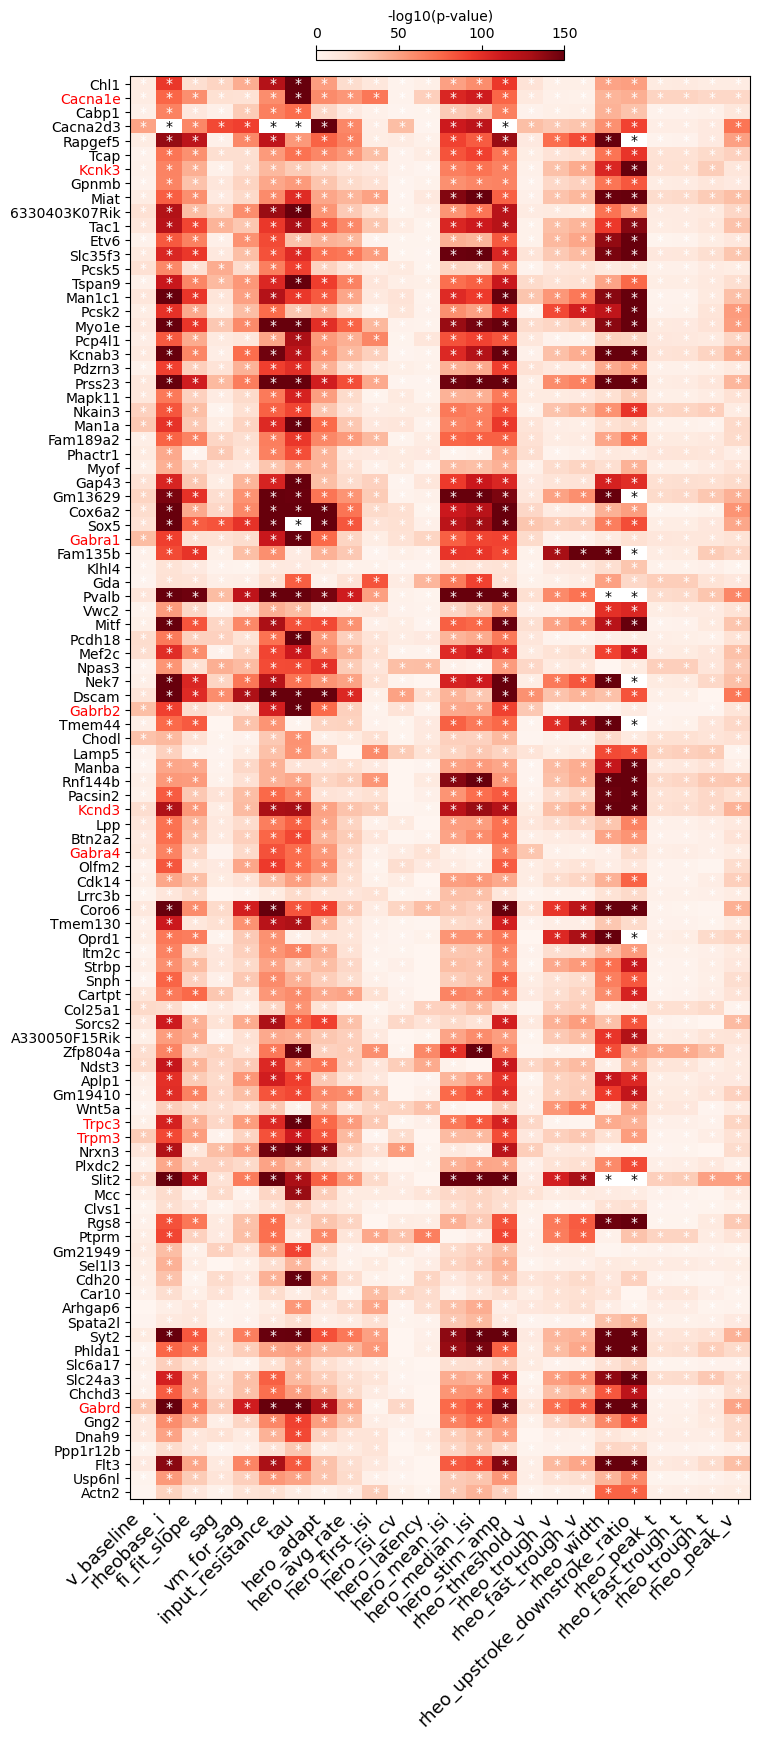

In [ ]:
VGIC_LGIC = np.load("proc/VGIC_LGIC.npy", allow_pickle= True)
top = 100
p_value_matrix = top_100
ephys_matrix = p_value_matrix

IC_idx = np.flatnonzero(np.isin(p_value_matrix.index, VGIC_LGIC))

# Plotting parameters
vmin=0
vmax=150
cmap = "Reds"
colorbar_label = "-log10(p-value)"
textcolors=("black", "white")
kw = dict(horizontalalignment="center", verticalalignment="center")

# Plotting starts here
fig, axs = plt.subplots(1, 1, figsize=(8, 2+1*5*(top/25)), sharey=True)
plt.subplots_adjust(wspace=0.05)

im = axs.imshow(-np.log10(p_value_matrix), aspect="auto", cmap = cmap, vmin = vmin, vmax = vmax)
axs.set_xticks(np.arange(len(p_value_matrix.columns)))
axs.set_yticks(np.arange(len(p_value_matrix.index)))
axs.set_xticklabels(p_value_matrix.columns, rotation=45, ha='right', fontsize = 13)

# setting yticklabels
yticklabels = p_value_matrix.index.to_list()
y_labels = axs.get_yticklabels()
for i in IC_idx:
    y_labels[i].set_color("red")
axs.set_yticklabels(yticklabels)

# add asteriks to significant correlations
fdr = np.vectorize({True: "*", False: " "}.get)(p_value_matrix< 0.05)
texts = []
for i in range(fdr.shape[0]):
    for j in range(fdr.shape[1]):
        kw.update(color=textcolors[int(im.norm(p_value_matrix.iloc[i, j]) > 0)])
        text = im.axes.text(j, i, fdr[i, j], **kw)
        texts.append(text) 
        
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin = vmin, vmax = vmax), 
            cmap=cmap), ax=axs, shrink=0.4, aspect = 25, location = "top", 
            pad = 0.01, label = colorbar_label)

# Locations

In [29]:
adata.var

,chromosome,start,end,strand,intron_motif,annotation,unique,multi,max_overhang,i,canonical_start,gene_id_start,canonical_end,gene_id_end,n_genes,gene_id,gene_name,intron_group,n_genes_per_intron_group,intron_group_size
0,Y,897900,898549,+,1,0,90,0,25,2569,2,,1,ENSMUSG00000056673,1,ENSMUSG00000056673,Kdm5d,Kdm5d_Y_898549_+,1,2
1,Y,898116,898549,+,1,1,1734,0,22,2573,1,ENSMUSG00000056673,1,ENSMUSG00000056673,1,ENSMUSG00000056673,Kdm5d,Kdm5d_Y_898549_+,1,2
2,Y,1012170,1014633,+,1,1,3970,1,19,2655,1,ENSMUSG00000069049,1,ENSMUSG00000069049,1,ENSMUSG00000069049,Eif2s3y,Eif2s3y_Y_1014633_+,1,3
3,Y,1013474,1014633,+,1,1,2569,2,5,2662,1,ENSMUSG00000069049,1,ENSMUSG00000069049,1,ENSMUSG00000069049,Eif2s3y,Eif2s3y_Y_1014633_+,1,3
4,Y,1014320,1014633,+,1,0,110,0,22,2664,2,,1,ENSMUSG00000069049,1,ENSMUSG00000069049,Eif2s3y,Eif2s3y_Y_1014633_+,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37246,1,194812318,194813367,-,2,1,140,8,21,954655,1,ENSMUSG00000016481,0,ENSMUSG00000016481,1,ENSMUSG00000016481,Cr1l,Cr1l_1_194812318_-,1,5
37247,1,194812318,194813395,-,2,1,130,0,25,954656,1,ENSMUSG00000016481,0,ENSMUSG00000016481,1,ENSMUSG00000016481,Cr1l,Cr1l_1_194812318_-,1,5
37248,1,194812318,194813495,-,2,1,2349,248,14,954658,1,ENSMUSG00000016481,1,ENSMUSG00000016481,1,ENSMUSG00000016481,Cr1l,Cr1l_1_194812318_-,1,5
37249,1,194812318,194813672,-,2,0,107,10,25,954659,1,ENSMUSG00000016481,2,,1,ENSMUSG00000016481,Cr1l,Cr1l_1_194812318_-,1,5


# Individual events

In [3]:
glm_results

path,Lamp5,Pvalb,Serpinf1,Sncg,Sst,Vip,cpm,fi_fit_slope,hero_adapt,hero_avg_rate,...,rheo_trough_v,rheo_upstroke_downstroke_ratio,rheo_width,rheobase_i,sag,soma_depth,subclass,tau,v_baseline,vm_for_sag
event_name,,,,,,,,,,,,,,,,,,,,,
Fgf12_16_28217141_-,8.854097e-35,1.884280e-143,0.020971,3.598666e-29,4.662889e-02,6.723599e-39,4.125203e-68,2.403128e-60,2.349352e-17,5.154503e-44,...,8.344152e-30,2.769221e-186,2.041584e-109,1.987418e-80,3.541250e-03,3.322655e-04,8.592824e-222,1.201326e-19,0.004616,1.482759e-27
Rapgef4_2_71967585_+,9.322634e-289,1.789853e-30,0.941450,1.542040e-14,3.874197e-114,6.006884e-07,1.792904e-25,1.338182e-09,1.353395e-05,3.871103e-02,...,2.323360e-12,1.163569e-165,2.800063e-167,1.349278e-02,3.456956e-04,2.386563e-13,0.000000e+00,3.363161e-44,0.008557,5.503201e-02
Dlgap1_17_70900161_+,6.297608e-56,1.192568e-53,0.472999,1.498848e-07,2.983444e-67,6.357260e-32,9.696901e-30,4.402262e-16,4.528708e-07,6.770749e-15,...,6.321606e-13,1.342598e-75,6.335871e-60,6.467559e-44,3.773406e-13,1.312609e-06,3.970667e-172,6.675335e-53,0.020504,1.501573e-20
Snhg11_2_158227192_+,9.548597e-08,8.137186e-67,0.394574,9.241396e-05,3.697797e-27,3.686558e-03,3.650282e-03,4.146554e-32,1.880660e-02,4.512052e-34,...,7.025007e-08,1.508227e-45,6.196590e-36,1.311762e-34,3.555468e-04,6.976860e-02,3.339203e-81,1.057010e-20,0.003831,1.310357e-05
Plekha5_6_140470590_+,1.150498e-22,2.974732e-22,0.011149,1.575831e-05,4.180233e-01,5.383469e-47,2.860045e-01,3.866055e-07,3.923637e-08,2.745764e-06,...,1.295488e-19,1.827191e-20,9.334505e-09,2.057996e-21,1.018994e-02,1.987035e-03,1.615199e-90,1.955818e-04,0.032193,8.278305e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kctd2_11_115320711_+,9.957977e-01,8.964213e-01,1.000000,1.000000e+00,6.403984e-01,1.702521e-01,3.740215e-01,8.521375e-01,5.827435e-01,9.480759e-01,...,5.670661e-01,9.346071e-01,9.590605e-01,5.817412e-01,8.990857e-01,8.299232e-01,1.538735e-01,5.647065e-01,0.610515,7.401422e-01
Kctd2_11_115321138_+,9.604410e-01,8.878049e-01,0.749629,6.342932e-01,8.086494e-01,8.476946e-01,9.972853e-01,8.162196e-01,4.854697e-01,9.034884e-01,...,8.509829e-01,4.913506e-01,7.890338e-01,9.998795e-01,7.856607e-01,7.918942e-01,3.974651e-01,8.550084e-01,0.881378,7.991599e-01
Kctd6_14_14249623_-,5.947122e-01,7.723246e-01,0.540671,4.456224e-01,9.342683e-01,8.215900e-01,9.592262e-01,4.733624e-01,9.524856e-01,4.835805e-01,...,2.524773e-01,3.765821e-01,2.707099e-01,1.000000e+00,5.875847e-01,9.431253e-01,1.054977e-01,9.557307e-01,0.892284,9.989309e-01


# FGF12

 FGF12 (FHF1) gene encodes voltage-gated sodium channel (Nav)-binding protein fibroblast growth factor homologous factor 1, which could cause seizures by regulating voltage dependence of Nav fast inactivation and neuron excitability. The most common pathogenic variant FGF12 c.341G > A related early-onset epileptic encephalopathies (EOEE) was characterized by intractable seizures and developmental disabilities.  FGF12 (FHF1) gene encodes voltage-gated sodium channel (Nav)-binding protein fibroblast growth factor homologous factor 1, which could cause seizures by regulating voltage dependence of Nav fast inactivation and neuron excitability. The most common pathogenic variant FGF12 c.341G > A related early-onset epileptic encephalopathies (EOEE) was characterized by intractable seizures and developmental disabilities. 
 
 Physiologically, FGF12 is expressed in two different transcripts resulting from alternative splicing, which differ only in their N-terminal part. Our results demonstrated that the expression of WTA, with its longer N-terminal part, has a stronger effect on the fast inactivation of NaV1.6 than WTB with its shorter N-terminal part, which is in line with previous studies.

# Gene expression-level

In [ ]:
transcriptomics_sample_id_file_name = json.load(open("data/mappings/transcriptomics_sample_id_file_name.json"))
cpm = pd.read_csv("data/20200513_Mouse_PatchSeq_Release_cpm.v2.csv", index_col = 0)
cpm = cpm.T
cpm.index = cpm.index.map(transcriptomics_sample_id_file_name)
cpm = cpm.reset_index().dropna(subset=["index"]).set_index("index") # drop NaN indices
ephys_data_sc = pd.read_csv("data/ephys_data_sc.csv", index_col = 0)
ephys_data_sc = ephys_data_sc.loc[(np.isnan(ephys_data_sc)).sum(axis = 1) < 6, :]
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
ephys_data_sc = pd.DataFrame(imp.fit_transform(ephys_data_sc), index=ephys_data_sc.index, columns=ephys_data_sc.columns)
commin_ids = np.intersect1d(ephys_data_sc.index, cpm.index)
ephys_data_sc = ephys_data_sc.loc[commin_ids]
cpm = cpm.loc[commin_ids]
cpm = cpm.loc[:, cpm.sum(axis = 0) > 20]
gene_ephys_rank_p = correlate(cpm.values, ephys_data_sc.values, rank = True).p
gene_ephys_rank_p = correlate(cpm.values, ephys_data_sc.values, rank = True).p
gene_ephys_rank_p = pd.DataFrame(
    fdrcorrection(gene_ephys_rank_p.flatten())[1].reshape(gene_ephys_rank_p.shape), 
    index = cpm.columns, 
    columns = ephys_data_sc.columns)
top_100 = gene_ephys_rank_p.loc[gene_ephys_rank_p.apply(lambda x: (x < 0.05)).sum(axis = 1).sort_values(ascending = False)[:100].index]

: 

/scratch/s/shreejoy/nxu/patch_seq_spl/env/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


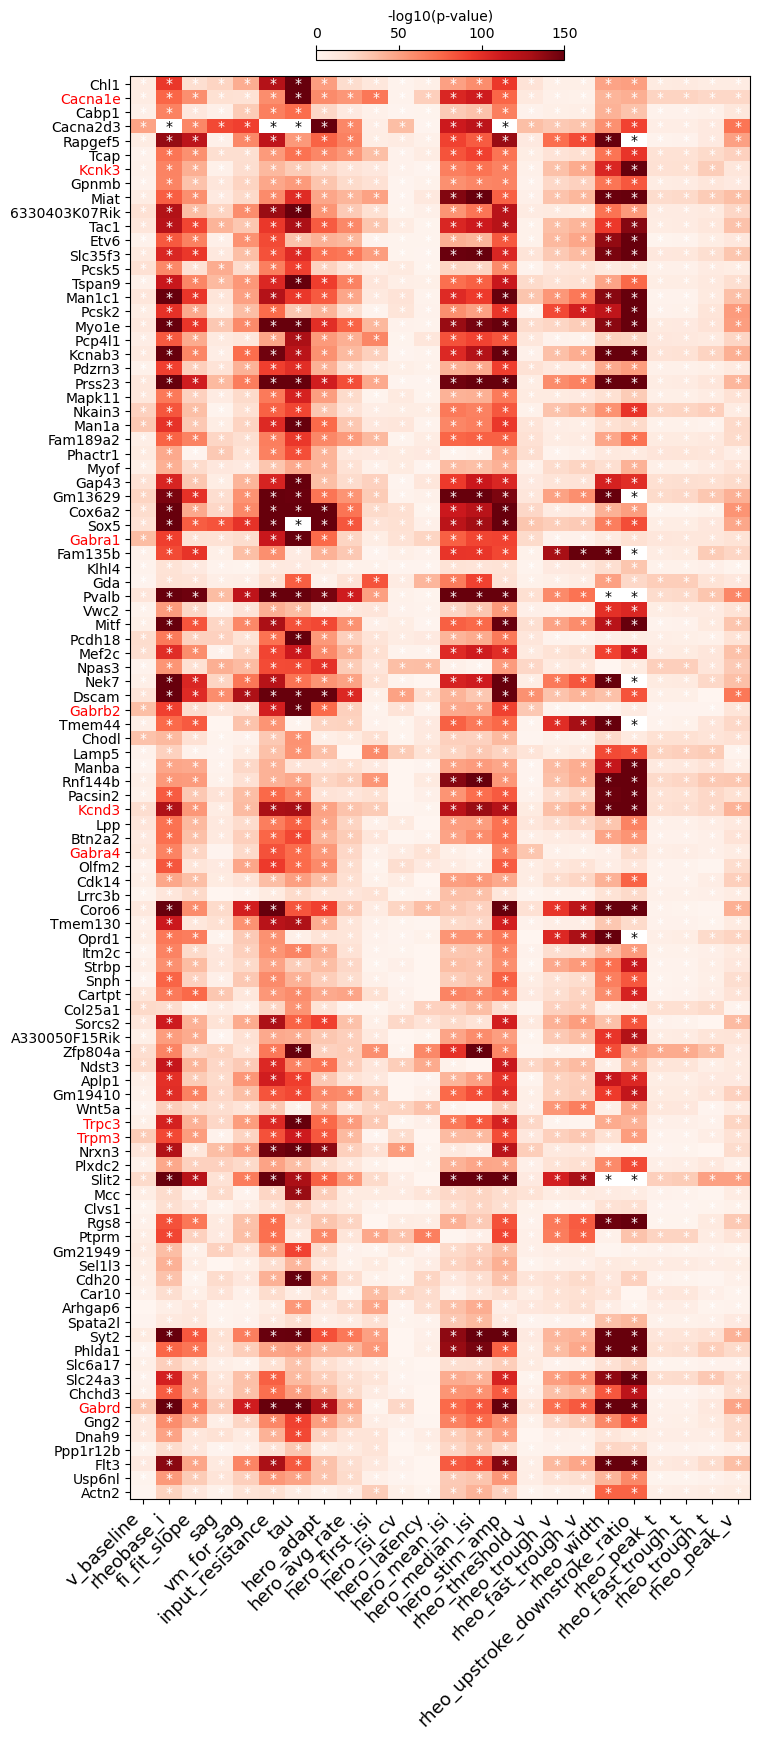

In [ ]:
VGIC_LGIC = np.load("proc/VGIC_LGIC.npy", allow_pickle= True)
top = 100
p_value_matrix = top_100
ephys_matrix = p_value_matrix

IC_idx = np.flatnonzero(np.isin(p_value_matrix.index, VGIC_LGIC))

# Plotting parameters
vmin=0
vmax=150
cmap = "Reds"
colorbar_label = "-log10(p-value)"
textcolors=("black", "white")
kw = dict(horizontalalignment="center", verticalalignment="center")

# Plotting starts here
fig, axs = plt.subplots(1, 1, figsize=(8, 2+1*5*(top/25)), sharey=True)
plt.subplots_adjust(wspace=0.05)

im = axs.imshow(-np.log10(p_value_matrix), aspect="auto", cmap = cmap, vmin = vmin, vmax = vmax)
axs.set_xticks(np.arange(len(p_value_matrix.columns)))
axs.set_yticks(np.arange(len(p_value_matrix.index)))
axs.set_xticklabels(p_value_matrix.columns, rotation=45, ha='right', fontsize = 13)

# setting yticklabels
yticklabels = p_value_matrix.index.to_list()
y_labels = axs.get_yticklabels()
for i in IC_idx:
    y_labels[i].set_color("red")
axs.set_yticklabels(yticklabels)

# add asteriks to significant correlations
fdr = np.vectorize({True: "*", False: " "}.get)(p_value_matrix< 0.05)
texts = []
for i in range(fdr.shape[0]):
    for j in range(fdr.shape[1]):
        kw.update(color=textcolors[int(im.norm(p_value_matrix.iloc[i, j]) > 0)])
        text = im.axes.text(j, i, fdr[i, j], **kw)
        texts.append(text) 
        
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin = vmin, vmax = vmax), 
            cmap=cmap), ax=axs, shrink=0.4, aspect = 25, location = "top", 
            pad = 0.01, label = colorbar_label)